In [3]:
#pip install scipy pandas numpy statistics geojson plotly

In [238]:
from sqlalchemy import create_engine, text, inspect, Table
import pandas as pd
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import numpy as np

In [7]:
engine = create_engine("postgresql://student:infomdss@db_dashboard:5432/dashboard")

In [249]:
query_6 = '''SELECT * FROM electricity_consumption'''
con = engine.connect()
dfpred = pd.read_sql(query_6, con, index_col = "index" )

In [250]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [251]:
dfpred.drop("Unnamed: 0", axis = 1, inplace = True)
dfpred['DATE'] = pd.to_datetime(dfpred[['year', 'month']].assign(day=1))
dfpred.drop("year", axis = 1, inplace= True)
dfpred.drop("month", axis = 1, inplace = True)
dcountry = "AUT"
dindicator = "Consumption"
dfpred = dfpred[(dfpred["country"] == dcountry) & (dfpred["indicator"] == dindicator)]
#dfpred["DATE"] = dfpred["DATE"].astype(str)
dfpred2 = dfpred[["DATE","gwh"]]
#dfpred2.dtypes
dfpred2.to_csv("elec_date.csv", index = False)

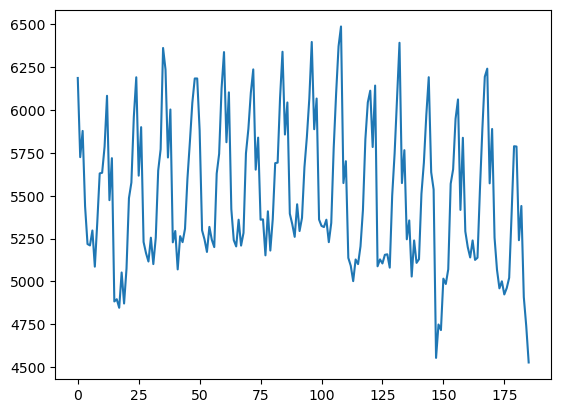

In [252]:
# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
values = series.values
# plot dataset
pyplot.plot(values)
pyplot.show()

>expected=5000.6, predicted=5107.2
>expected=4923.9, predicted=4961.4
>expected=4961.2, predicted=5043.3
>expected=5021.2, predicted=5514.7
>expected=5395.3, predicted=5426.9
>expected=5788.7, predicted=5687.5
>expected=5787.0, predicted=6075.7
>expected=5240.4, predicted=6063.4
>expected=5440.1, predicted=5616.9
>expected=4908.5, predicted=5791.8
>expected=4739.4, predicted=5195.2
>expected=4526.9, predicted=4853.7
MAE: 317.239


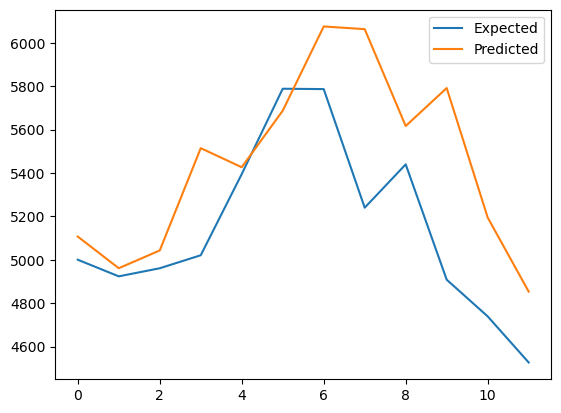

In [253]:
# forecast monthly births with random forest
## DIT MOet ER NIET IN DIT IS ALLEEN OM DE PARAMETERS TE OPTIMALISEREN GA IK NOG DOEN
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [281]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# load a smaller sample of the dataset
series = read_csv('elec_date.csv', header=0, index_col=0, nrows=100)  # Adjust nrows to your desired sample size
values = series.values

# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6, n_out=6)  # Reduce n_in and n_out for a smaller sample
# split into input and output columns
trainX, trainy = train[:, :-6], train[:, -6:]

# Define hyperparameters to try
hyperparameters = {
    'n_estimators': [100, 500],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Create RandomForestRegressor
rf_model = RandomForestRegressor()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=hyperparameters, cv=3)
grid_result = grid_search.fit(trainX, trainy)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_result.best_params_)

# fit model with the best hyperparameters
best_model = RandomForestRegressor(**grid_result.best_params_)
best_model.fit(trainX, trainy)

# construct an input for a new prediction
row = values[-6:].flatten()

# make a 6-step prediction (adjust to your desired prediction steps)
yhat = best_model.predict(asarray([row]))
print('Input: %s, Predicted: %s' % (row, yhat))


/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.11/site-packages/sklearn/utils/

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Input: [5843. 6067. 6397. 5888. 6067. 5361.], Predicted: [[5305.778 5211.604 5380.498 5240.204 5347.232 5666.976]]


In [279]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# load the dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
values = series.values

# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=12, n_out=12)
# split into input and output columns
trainX, trainy = train[:, :-12], train[:, -12:]

# Define hyperparameters to try
hyperparameters = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create RandomForestRegressor
rf_model = RandomForestRegressor()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=hyperparameters, cv=3)
grid_result = grid_search.fit(trainX, trainy)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_result.best_params_)

# fit model with the best hyperparameters
best_model = RandomForestRegressor(**grid_result.best_params_)
best_model.fit(trainX, trainy)

# construct an input for a new prediction
row = values[-12:].flatten()

# make a 12-step prediction
yhat = best_model.predict(asarray([row]))
print('Input: %s, Predicted: %s' % (row, yhat))


KeyboardInterrupt: 

In [271]:
# DIT IS DE UITEINDELIJKE PREDICTOR NOg niet geoptimaliseerd nu
# als je de maanden wil aanpassen doe je n_out in de onderste naar meer maanden en
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# load the dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
#series = dfpred2["gwh"]
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=50, n_out=40)  # Update n_out to 5
# split into input and output columns
trainX, trainy = train[:, :-40], train[:, -40:]  # Separate the last 5 columns as output
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = values[-50:].flatten()

# make a 5-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %s' % (row, yhat))


Input: [5355.76  5028.373 5238.936 5108.134 5129.621 5510.255 5692.274 5970.166
 6191.459 5637.256 5536.454 4553.688 4748.615 4715.88  5016.111 4984.917
 5070.661 5569.589 5653.941 5948.676 6061.711 5417.159 5837.977 5292.216
 5200.376 5139.668 5238.894 5125.441 5138.257 5534.87  5889.139 6194.275
 6241.162 5572.221 5889.35  5254.954 5067.914 4959.545 5000.562 4923.9
 4961.22  5021.191 5395.307 5788.714 5787.018 5240.429 5440.089 4908.547
 4739.386 4526.915], Predicted: [[5274.509228 5269.986074 5348.827523 5626.386324 5826.757458 6005.591089
  6125.140145 5774.218697 5751.329371 5332.515965 5247.022284 5174.781722
  5261.13088  5251.028093 5347.563668 5642.181535 5839.878028 6006.28082
  6114.408968 5727.809665 5679.965971 5284.716135 5219.617172 5145.416845
  5237.889851 5228.180707 5342.562637 5624.079504 5834.380169 6004.60625
  6097.427063 5735.161631 5719.003583 5287.915702 5187.316055 5135.216822
  5199.114501 5198.401936 5286.995244 5551.755029]]


In [273]:
resultsplot = pd.DataFrame(series)
resultsplot = resultsplot.reset_index()
resultsplot["DATE"] = pd.to_datetime(resultsplot["DATE"])
resultsplot["predict"] = False

In [275]:
result = yhat.reshape(-1)
for value in result:
    last_date = resultsplot["DATE"].max()
    new_date = last_date + pd.DateOffset(months=1)
    list_row = [new_date, value, True]
    resultsplot.loc[len(resultsplot)] = list_row
resultsplot.tail(7)
    

,DATE,gwh,predict
259,2029-08-01,5287.915702,True
260,2029-09-01,5187.316055,True
261,2029-10-01,5135.216822,True
262,2029-11-01,5199.114501,True
263,2029-12-01,5198.401936,True
264,2030-01-01,5286.995244,True
265,2030-02-01,5551.755029,True


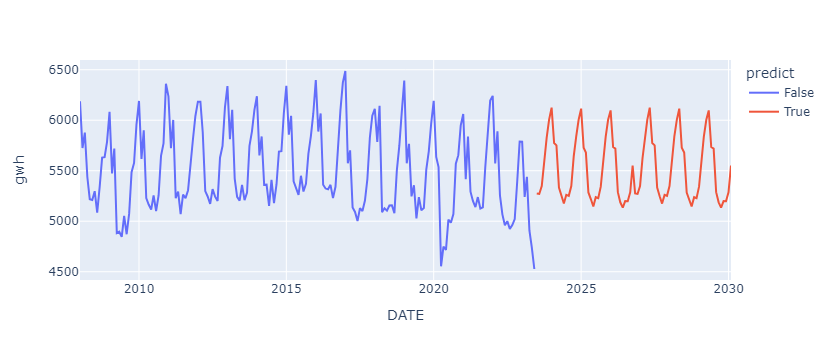

In [276]:
fig = px.line(resultsplot, x = "DATE",y ="gwh", color = "predict" )
fig.show()